In [326]:
import pymysql as sql
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from sklearn import cluster, preprocessing
import math
import os
import rds_config
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
from __future__ import division
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import warnings
warnings.filterwarnings('ignore')

import helper_functions

In [327]:
# open database
engine = helper_functions.create_db_engine()

In [328]:
df_team_game_stats = pd.read_sql('''SELECT tgs.GameID, tgs.Date, tgs.TeamID, tgs.FinalScore, tgs.Pace, tgs.DRtg,
                                            opp.TeamID as OppTeamID, opp.FinalScore as OppScore,
                                            opp.3PA as Opp3PA, opp.3P as Opp3P
                                        FROM BasketballDatabase.TeamGameStatsYTD tgs
                                        JOIN BasketballDatabase.TeamGameStatsYTD opp 
                                            on (tgs.GameID = opp.GameID and tgs.TeamID <> opp.TeamID)
                                        ORDER BY GameID''', con=engine)

df_team_game_stats = helper_functions.create_expanding_sum_col(df_team_game_stats, 'Opp3PA', 'OppTotal3PA', 'TeamID')
df_team_game_stats = helper_functions.create_expanding_sum_col(df_team_game_stats, 'Opp3P', 'OppTotal3P', 'TeamID')
df_team_game_stats = helper_functions.create_expanding_mean_col(df_team_game_stats, 'Opp3PA', 'OppAvg3PAAllowed', 'TeamID', 10)
df_team_game_stats = helper_functions.create_expanding_mean_col(df_team_game_stats, 'Pace', 'AvgPace', 'TeamID', 10)
df_team_game_stats = helper_functions.create_expanding_mean_col(df_team_game_stats, 'DRtg', 'AvgDRtg', 'TeamID', 10)

df_team_game_stats['Opp3PPercent'] = df_team_game_stats['OppTotal3P'] / df_team_game_stats['OppTotal3PA']

df_team_game_stats['RestDays'] = ((df_team_game_stats['Date'] - df_team_game_stats.groupby('TeamID')['Date'].shift(1)).apply(
    lambda x: x.astype('timedelta64[h]') / np.timedelta64(1, 'h')) / 24).round()

df_team_game_stats.drop(['Opp3PA', 'Opp3P', 'OppTotal3P', 'OppTotal3PA'], axis=1, inplace=True)

df_team_game_stats = df_team_game_stats.merge(df_team_game_stats, left_on=['GameID', 'OppTeamID'], right_on=['GameID', 'TeamID'],
                                             suffixes=['', '_Opp'])

df_team_game_stats[df_team_game_stats['TeamID'] == 15]['AvgDRtg'].tolist()

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 107.54000000000001,
 108.15454545454546,
 105.29166666666667,
 103.69999999999999,
 103.41428571428571,
 102.24666666666667,
 102.18125000000001,
 103.13529411764706,
 103.37777777777779,
 104.88947368421053,
 104.69000000000001,
 104.89047619047621,
 104.51363636363637,
 103.97391304347826,
 103.40833333333335,
 102.956,
 103.16153846153847,
 102.80370370370372,
 102.925,
 102.70344827586207,
 103.11666666666666,
 102.85161290322581,
 103.27500000000001,
 103.87272727272727,
 104.35000000000001,
 103.92285714285715,
 104.30277777777778,
 104.82162162162163,
 105.25,
 105.40512820512821,
 105.01000000000002,
 105.07804878048782,
 105.13095238095241,
 105.26976744186049,
 105.5386363636364,
 105.37111111111115,
 105.78913043478265,
 105.88297872340429,
 106.25208333333337,
 106.44897959183677,
 106.35000000000004,
 106.26078431372552,
 106.55576923076927,
 106.69245283018873,
 106.24259259259263,
 106.06363636363639,
 106.3892

In [329]:
df_player_game_stats = pd.read_sql('''SELECT g.Player, pgs.GameID, pgs.PlayerID, pgs.TeamID, pgs.MP, pgs.PTS,
                                        pgs.DRtg as PlayerDRtg, tgs.PACE
                                        FROM BasketballDatabase.PlayerGameStatsYTD pgs
                                        JOIN BasketballDatabase.TeamGameStatsYTD tgs 
                                                on (tgs.GameID = pgs.GameID and tgs.TeamID = pgs.TeamID)
                                        JOIN GeneralPlayerInfo g on g.PlayerID = pgs.PlayerID
                                        ORDER BY GameID''', con=engine)

df_player_game_stats['MP'] = df_player_game_stats['MP'].apply(helper_functions.minutes_played)
df_player_game_stats = helper_functions.create_expanding_mean_col(df_player_game_stats, 'PTS', 'PPG', 'PlayerID', 10)
    
df_player_game_stats[df_player_game_stats['PlayerID'] == 612]

,Player,GameID,PlayerID,TeamID,MP,PTS,PlayerDRtg,PACE,PPG
12,LeBron James,20599,612,6,32.383333,19,90,99.9,NaN
505,LeBron James,20622,612,6,38.666667,21,100,93.9,NaN
607,LeBron James,20626,612,6,39.000000,23,103,96.5,NaN
1005,LeBron James,20644,612,6,35.850000,19,127,92.8,NaN
1412,LeBron James,20663,612,6,36.366667,30,124,99.4,NaN
1859,LeBron James,20683,612,6,35.866667,25,96,102.3,NaN
2193,LeBron James,20699,612,6,36.866667,23,107,97.6,NaN
2789,LeBron James,20726,612,6,38.100000,27,90,97.4,NaN
3036,LeBron James,20738,612,6,38.700000,19,99,92.5,NaN
3324,LeBron James,20751,612,6,38.066667,28,117,99.0,NaN


In [330]:
df_player_game_stats = df_player_game_stats.merge(df_team_game_stats, how='left', on=['GameID', 'TeamID'])
df_player_game_stats = df_player_game_stats[(df_player_game_stats['RestDays'] != 8) & (df_player_game_stats['RestDays'] != 9)
                                           & (df_player_game_stats['RestDays'] != 5)]

df_player_game_stats = df_player_game_stats.dropna().reset_index(drop=True)

df_player_game_stats['RestDaysDiff'] = df_player_game_stats['RestDays'] - df_player_game_stats['RestDays_Opp']
df_player_game_stats['AvgDRtgOrig_Opp'] = df_player_game_stats['AvgDRtg_Opp']

df_player_game_stats = helper_functions.standard_scaler(df_player_game_stats, ['Opp3PPercent', 'PPG', 'AvgPace_Opp', 'AvgDRtg_Opp'])

df_player_game_stats[df_player_game_stats['PlayerID'] == 612]

,Player,GameID,PlayerID,TeamID,MP,PTS,PlayerDRtg,PACE,Date,FinalScore,...,OppScore_Opp,OppAvg3PAAllowed_Opp,Opp3PPercent_Opp,RestDays_Opp,RestDaysDiff,AvgDRtgOrig_Opp,Opp3PPercent,PPG,AvgPace_Opp,AvgDRtg_Opp
282,LeBron James,20774,612,6,28.050000,21,91,95.3,2016-11-18 19:30:00,104,...,104,23.250000,0.340502,2,0,102.975000,-0.244249,2.162451,-0.626600,-2.023930
1106,LeBron James,20824,612,6,29.050000,19,94,96.7,2016-11-25 19:30:00,128,...,128,26.428571,0.402703,2,0,106.785714,0.113308,2.232546,-1.596699,-0.657537
1533,LeBron James,20848,612,6,41.500000,26,110,96.6,2016-11-27 13:00:00,112,...,112,26.125000,0.339713,2,0,107.562500,-0.595678,2.172406,0.513667,-0.379008
1765,LeBron James,20860,612,6,32.883333,22,122,99.6,2016-11-29 20:00:00,101,...,101,28.800000,0.312500,2,0,106.466667,-0.133125,2.201735,-0.123660,-0.771937
2026,LeBron James,20875,612,6,33.616667,16,116,94.7,2016-12-01 20:00:00,94,...,94,23.631579,0.365256,2,0,102.052632,-0.095755,2.184019,0.010514,-2.354661
2136,LeBron James,20881,612,6,44.666667,27,118,97.0,2016-12-02 20:00:00,105,...,105,24.235294,0.361650,2,-1,104.600000,0.162746,2.107859,-0.449930,-1.441261
2729,LeBron James,20911,612,6,42.016667,34,119,92.9,2016-12-05 19:30:00,116,...,116,28.000000,0.344643,2,1,107.760000,-0.267956,2.145324,-0.681577,-0.308192
2983,LeBron James,20925,612,6,32.450000,25,101,93.8,2016-12-07 20:00:00,126,...,126,25.428571,0.352060,1,1,110.319048,-0.064890,2.241532,0.010922,0.609396
3206,LeBron James,20936,612,6,37.316667,27,90,87.8,2016-12-09 19:30:00,114,...,114,22.181818,0.352459,2,0,106.713636,-0.066345,2.250991,-1.084743,-0.683382
3356,LeBron James,20944,612,6,42.450000,44,104,95.3,2016-12-10 19:30:00,116,...,116,30.869565,0.335211,1,0,103.717391,-0.445152,2.275680,0.197173,-1.757734


In [331]:
df_player_season_stats = pd.read_sql('''SELECT g.Player, g.Height, g.Weight, ps.*, p.PTSPerG, p.3PAPerG, a.FTr
                                        FROM BasketballDatabase.PlayerSeasonShootingStatsYTD ps
                                        JOIN BasketballDatabase.PlayerSeasonStatsPerGameYTD p on p.PlayerID = ps.PlayerID
                                        JOIN BasketballDatabase.PlayerSeasonAdvStatsYTD a on a.PlayerID = ps.PlayerID
                                        JOIN BasketballDatabase.GeneralPlayerInfo g on g.PlayerID = ps.PlayerID
                                        ''', con=engine)
df_player_season_stats = df_player_season_stats.drop_duplicates(subset=['PlayerID'], keep=False).reset_index(drop=True)

df_player_season_stats['Height'] = df_player_season_stats['Height'].apply(lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1]))

df_player_season_stats.drop(['FGPercent', 'AvgShotDist', 'Season', 'GameTypeID', 'TeamID'], axis=1, inplace=True)
df_player_game_stats.drop(['GameID', 'PlayerDRtg', 'Date', 'OppTeamID_Opp',
                           'OppScore_Opp', 'Pace_Opp', 'Date_Opp', 'OppTeamID',
                           'FinalScore_Opp', 'OppAvg3PAAllowed_Opp', 'Opp3PPercent_Opp',
                           'OppAvg3PAAllowed', 'OppAvg3PAAllowed', 'RestDaysDiff'], axis=1, inplace=True)

In [332]:
data = df_player_season_stats[['PercentFGA0to2ft', 'PercentFGA3to9ft', 'PercentFGA10to15ft',
                               'PercentFGA16Plusftto3', 'PercentFGA3P', 'Percent2PAAstByOthers',
                               'Percent3PAAstByOthers', 'Percent3PAFromCorner', 'FTr', 'Height', 'Weight']]

data = helper_functions.standard_scaler(data)

rand_state = 25
y_pred = cluster.KMeans(n_clusters=6, random_state=rand_state).fit_predict(data)
df_class = pd.DataFrame({'Class': y_pred})

In [333]:
df_player_season_stats = pd.concat([df_player_season_stats, df_class], axis=1)
df_player_class = df_player_season_stats[['PlayerID', 'Class']]

In [338]:
class_0_PIds = df_player_class[df_player_class['Class'] == 0]['PlayerID'].tolist()
df_class_0 = df_player_game_stats[df_player_game_stats['PlayerID'].isin(class_0_PIds)]
class_0_PIds

[5,
 25,
 156,
 216,
 283,
 455,
 527,
 644,
 660,
 665,
 673,
 675,
 688,
 694,
 736,
 750,
 774,
 784,
 787,
 808,
 834,
 851,
 877,
 898,
 906,
 917,
 968,
 973,
 974,
 988,
 995,
 1005,
 1031,
 1035,
 1043,
 1060,
 1062,
 1067,
 1068,
 1072,
 1076,
 1095,
 1121,
 1137,
 1152,
 1156,
 1167,
 1189,
 1233,
 1236,
 1244,
 1249,
 1275,
 1288,
 1292,
 1306,
 1308,
 1311,
 1312,
 1321,
 1335,
 1345,
 1346,
 1367,
 1372,
 1377,
 1395,
 1402,
 1410,
 1411,
 1417,
 1420,
 1424,
 1426,
 1434,
 1442,
 1445,
 1485,
 1495,
 1500,
 1503,
 1504,
 1509,
 1516,
 1527,
 1529,
 1540,
 1547,
 1548,
 1549,
 1550,
 1552,
 1553,
 1558,
 1559,
 1561,
 1572,
 1574,
 1575,
 1581,
 1584,
 1585,
 1590,
 1597,
 1598,
 1615,
 1630]

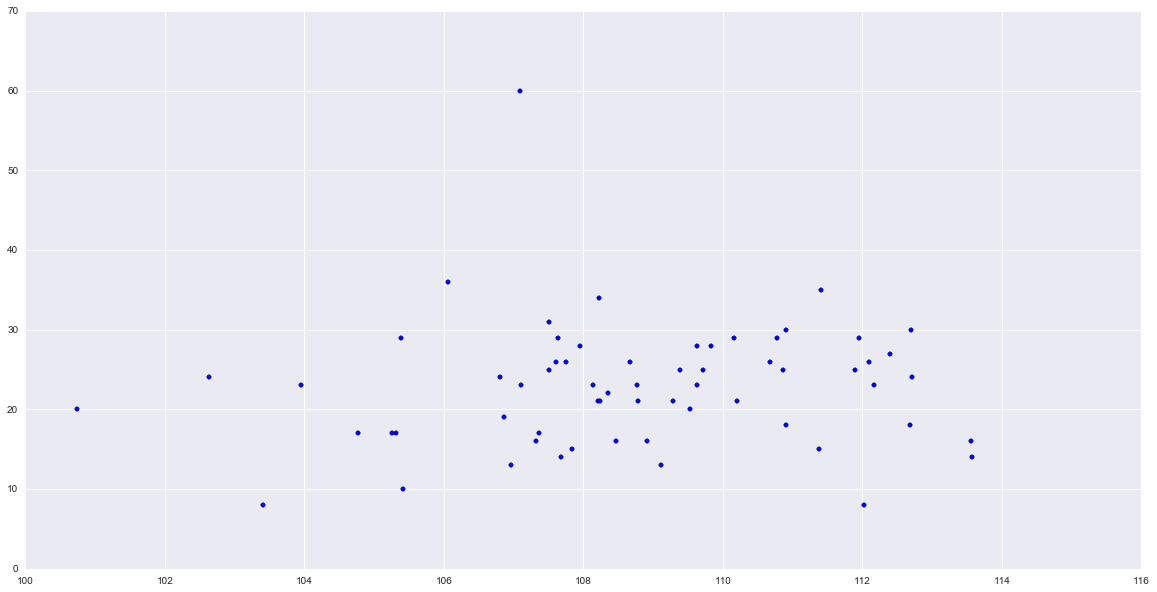

In [335]:
plt.scatter(df_class_0[df_class_0['PlayerID'] == 1152]['AvgDRtgOrig_Opp'], df_class_0[df_class_0['PlayerID'] == 1152]['PTS'])

In [336]:
df_class_0[(df_class_0['PlayerID'] == 1152) & (df_class_0['TeamID_Opp'] == 29)].sort(['PTS'], ascending=False)

,Player,PlayerID,TeamID,MP,PTS,PACE,FinalScore,Pace,DRtg,OppScore,...,AvgDRtg,RestDays,TeamID_Opp,DRtg_Opp,RestDays_Opp,AvgDRtgOrig_Opp,Opp3PPercent,PPG,AvgPace_Opp,AvgDRtg_Opp
4812,Klay Thompson,1152,10,31.216667,17,96.2,104,96.2,77.0,74,...,104.567857,3,29,108.2,2,104.771429,-2.103934,1.860893,-2.216283,-1.379792
3131,Klay Thompson,1152,10,27.900000,10,97.5,106,97.5,101.5,99,...,105.009091,1,29,108.7,2,105.413043,-1.950763,2.031576,-2.070968,-1.149731


In [337]:
lm = smf.ols("PTS ~ PPG", data=df_class_0[df_class_0['PPG'] > 0]).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     246.8
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           8.53e-51
Time:                        21:02:25   Log-Likelihood:                -4027.8
No. Observations:                1223   AIC:                             8060.
Df Residuals:                    1221   BIC:                             8070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.0567      0.291     34.608      0.0